# Temporal Analysis

In this python file the seven steps of PCA for the spatial analysis is set up

1. Standardize all input variables to z-score
2. Select data for the indicators that shape the social vulnerability based on the correlation matrix
3. Perform the PCA with the standardized input values
4. Select the number of components to be further used
5. Rotate the PCA solution
6. Interpretate the resulting components on how they might influence vulnerability. Based on this, signs are assigned to the components. The output of the loadings is the determining factor for assigning the sign. The indicator with the highest loading in the component determines the sign. If this indicator is positively correlated with the social vulnerability, a positive sign will be assigned and vice versa.
7. The component scores are combined into a univariate score based on the predetermined weighting scheme

In [ ]:
#import the packags
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy.stats as stats
from factor_analyzer import FactorAnalyzer

In [ ]:
#import the dataset
df = pd.read_csv('all_data_2021.csv', delimiter = ';', decimal = '.').set_index('Unnamed: 0')
df.head()

## 00. Data preprocessing

In [ ]:
# drop the information that is not necessary
df_working = df.drop(['year', 'measure_unit', 'stationary',  'included'])

In [ ]:
# show number of unique values
df_working.nunique()

In [ ]:
#drop all rows that contain only 1 unique value
df_working = df_working.drop(['Violent Conflict probability',
       'Highly Violent Conflict probability', 'Human Development Index',
       'Phisicians Density', 'Multidimensional Poverty Index',
       'Immunization rate (or 1-year-olds immunized against): DTC',
       'Tuberculosis prevalence',
       'Cholera Reported Cases', 
       'Health expenditure per capita', 'Malaria death rate',
       'Gender Inequality Index', 
       'HFA Scores Last recent', 'Government Effectiveness',
       'Corruption Perception Index', 'Access to electricity',
       'Adult liteacy rate', 'Internet users', 'Mobile cellular subscriptions',
                              'Mortality rate, under-5'
      
    ], axis = 1)

In [ ]:
for i in (df_working):
    print (i)
    if i != 'Persons in Need':
        df_working[i] = df_working[i].str.replace(',','.')
        df_working[i] = df_working[i].apply(pd.to_numeric, errors='coerce')

## 01. Standardization of data

In [ ]:
# standardize with z-score
df_std = df_working.select_dtypes(include='number').apply(stats.zscore)
df_std.head()

## 02. Select the indicators based on the correlation matrix

In [13]:
matrix = df_std.corr().round(2)

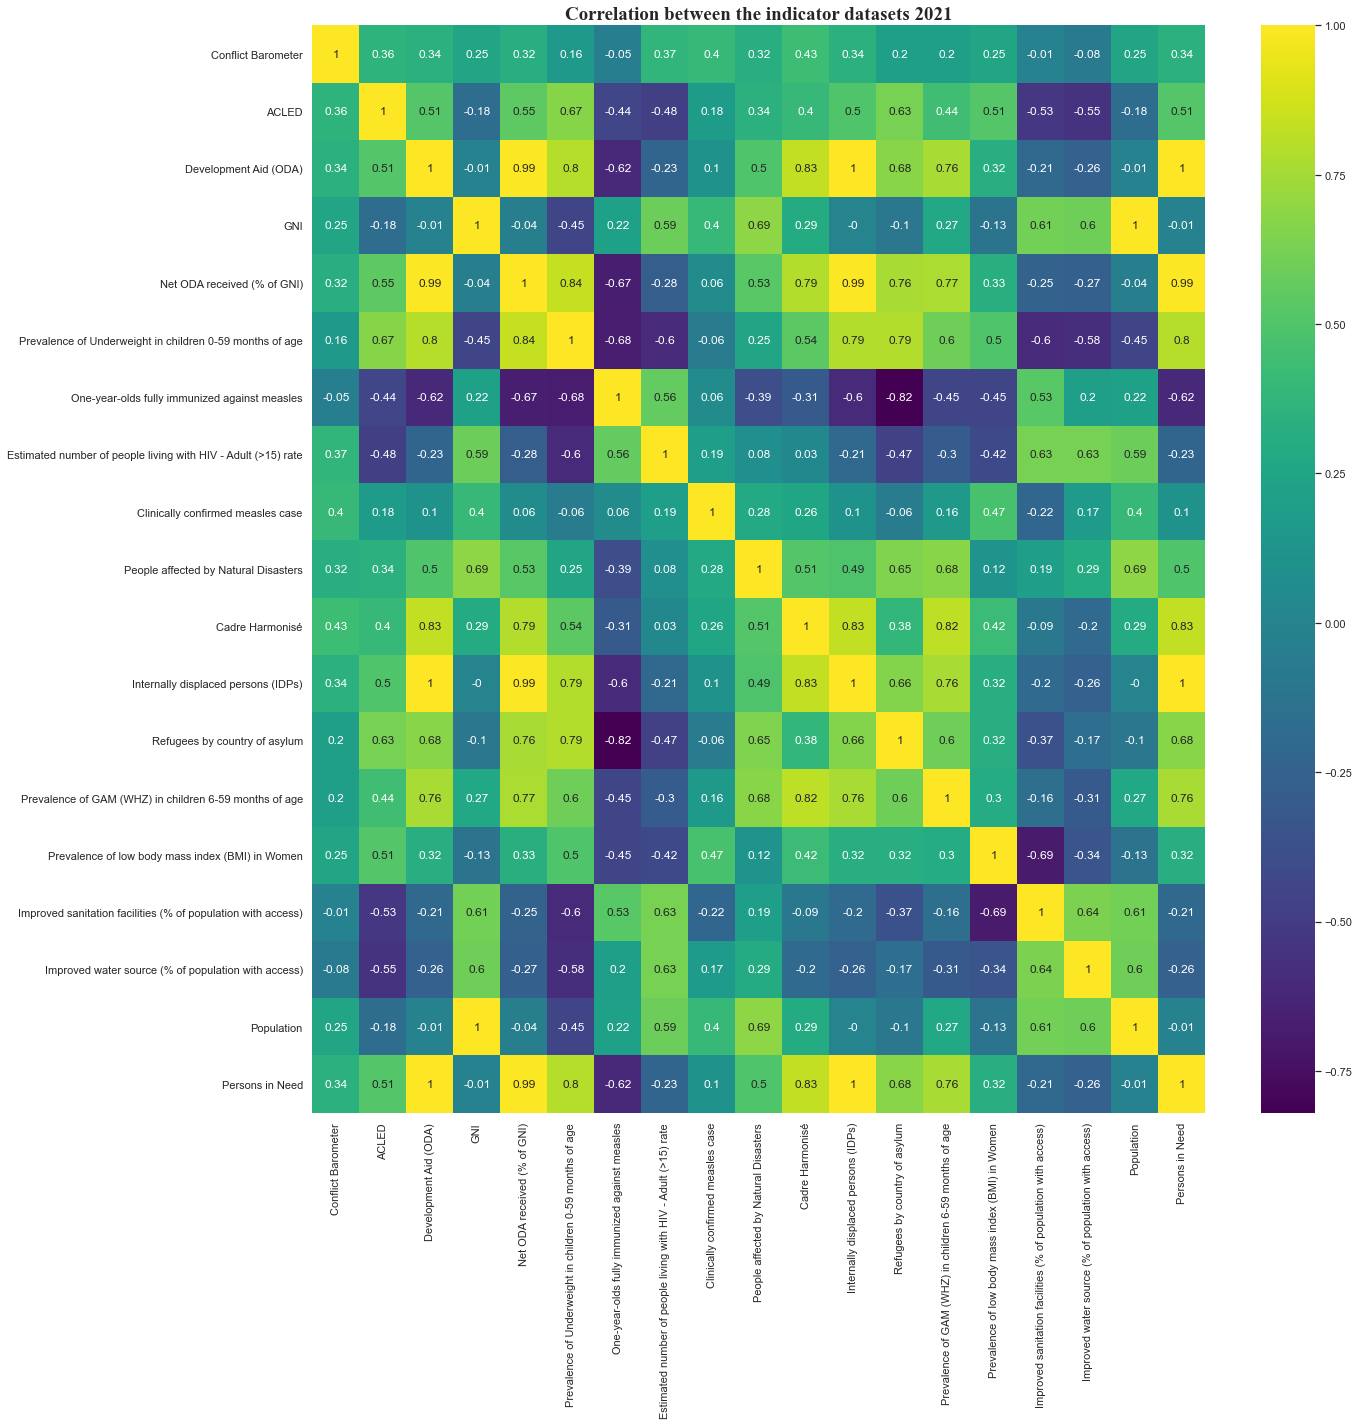

In [14]:
sns.set(rc = {'figure.figsize':(20, 20)})
sns_plot = sns.heatmap(matrix, annot=True, cmap = 'viridis')
plt.title('Correlation between the indicator datasets 2021', fontname="Times New Roman", fontweight = 'bold', fontsize = '45')
plt.savefig('correlation_indicators_2021.png')

plt.show()

Drop the variables on which other variables are based, based on pearson > 0.7


In [ ]:
df_std = df_std.drop([ 'Development Aid (ODA)',  'Net ODA received (% of GNI)', 'Prevalence of Underweight in children 0-59 months of age',
                      'Cadre Harmonisé', 'Refugees by country of asylum', 'Prevalence of GAM (WHZ) in children 6-59 months of age',  
                      'Population',  'Persons in Need'
                     ], axis = 1)

In [ ]:
#plot the correlation matrix again 
matrix = df_std.corr().round(2)
sns.set(rc = {'figure.figsize':(35, 35)})
sns_plot = sns.heatmap(matrix, annot=True, cmap = 'viridis',annot_kws={"fontsize":25})
plt.title('Correlation between the selected indicators', fontname="Times New Roman", fontweight = 'bold', fontsize = '40')
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
plt.savefig('correlation_indicators_2021_pearsons.png')
plt.show()

## 03. Perform the PCA

In [ ]:
# use factor analyzer to calculate PCA with varimax rotation
fa = FactorAnalyzer(n_factors=11, method='principal', rotation="varimax")
fa.fit(df_std)
loadings_all = (fa.loadings_.round(2))

In [ ]:
# plots original and common factor eigen values
fa.get_eigenvalues()

In [ ]:
# get variance
# for orignial vairance use fa.get_factor_variance[0]
# for proportional variance use fa.get_factor_variance[1]
# for cumulative variance use ga.get_factor_variance[2]

fa.get_factor_variance()


## 04. Select the number of components that is used for the analysis

Sort the data frame based on the amount of variance explained by each component

In [ ]:
# create a dataframe based on the loading, and name the column headers accordingly
df = pd.DataFrame(loadings_all, columns = ['PC1','PC2','PC3', 'PC4', 'PC5', 'PC6', 'PC7','PC8','PC9', 'PC10', 'PC11'])

# create list of variable names
indicator_names = df_std.columns.values.tolist()

# set list as index PC df of eigen vectors
df['variables'] = indicator_names
df = df.set_index('variables')

# round the number on two decimals
df = df.round(2)


In [ ]:
# append the dataframe with the explained variance of each principal component
variance = fa.get_factor_variance()[1]

df.loc[len(df.index)] = variance

# sort the data frame based on the explained variance 
df_sorted = df.sort_values(by =20, axis=1,ascending=False)


In [ ]:
# add a row with the cumulative variance to the data frame
cumulative_variance = []
cum_variance = 0

for i in df_sorted.columns:
    cum_variance += df_sorted[i][20]
    cumulative_variance.append(cum_variance)

In [ ]:
# sort the variance lists
sorted_cumulative = df_sorted.loc[21]
sorted_variance = df_sorted.loc[20]

In [ ]:
plt.plot(list(range(1,12)), sorted_cumulative, linewidth = 10)
plt.xlabel('Number of components', fontsize = 35, fontname="Times New Roman")
plt.ylabel('Cumulative explained variance',  fontsize = 35, fontname="Times New Roman")
plt.title('Cumulative explained variance, \n 7 PC are needed to explain 90% variance',  fontsize = 40, fontname="Times New Roman", fontweight = 'bold')
plt.yticks(fontsize=35)
plt.xticks(fontsize=35)
plt.axvline(x=7.4, color = 'grey', linestyle = '--', linewidth = 10)
plt.axhline(y=0.9, color='grey', linestyle='--', linewidth = 10)
plt.plot(7.4,.9, marker="o", color="red", markersize=20)
plt.savefig('90%variance_2021_sorted.png')
plt.show()

In [ ]:
PC_values =  list(range(1, 12))
plt.plot(PC_values,sorted_variance, 'ro-', linewidth=2)
plt.title('Scree Plot', fontsize = 45, fontname="Times New Roman", fontweight = 'bold' )
plt.xlabel('Principal Component', fontsize = 35, fontname="Times New Roman", fontweight = 'bold')
plt.ylabel('Proportion of Variance Explained', fontsize = 35, fontname="Times New Roman", fontweight = 'bold')
plt.savefig('Screeplot_2021_sorted.png')
plt.show()

## 05. Rotate the PCA with the right number of components

In [ ]:
#use factor analyzer to calculate PCA with varimax rotation, from the loading matrix, select the number of components that is needed
loading_matrix = df_sorted[['PC2', 'PC1', 'PC8', 'PC7', 'PC4', 'PC6', 'PC3']]

loading_matrix

Obtain the scores

In [ ]:
loading_matrix_scores = loading_matrix.drop([ 11, 12], axis =0)

In [ ]:
scores = df_std.dot(loading_matrix_scores)
score = scores.round(2)


## 06. Interpretate the resulting components on how they might influence vulnerability. 
Based on this, signs are assigned to the components. The output of the loadings is the determining factor for assigning the sign. The indicator with the highest loading in the component determines the sign. If this indicator is positively correlated with the social vulnerability, a positive sign will be assigned and vice versa

In [ ]:
def highlight(x):
    colors = 'background-color: lightgreen;'
    default = ''
    if type(x) in [float, int]:

        if x < -0.7:
            return colors
        elif x > 0.65:
            return colors
        else:
            return default
        
loading_matrix_scores.style.applymap(highlight)

In [ ]:
#set scores table to impact on vulnerbaility
scores['PC1'] = np.abs(scores['PC1'])*-1
scores['PC2'] = np.abs(scores['PC2'])
scores['PC3'] = np.abs(scores['PC3'])
scores['PC4'] = np.abs(scores['PC4'])
scores['PC8'] = np.abs(scores['PC8'])*-1
scores['PC7'] = np.abs(scores['PC7'])
scores['PC6'] = np.abs(scores['PC6'])

## 07. Calculate the scores for social vulnerability

In [ ]:
scores['vulnerability'] = scores.sum(axis = 1)


In [ ]:
scores.to_csv('vulnerability_cutter_2020_all_indi_varimax_try2_final.csv', decimal = ',') 

## 08. Interpretation of results

In [ ]:
scores = scores.rename(columns={'PC2': 'PC2 - Disaster', 'PC1': 'PC1 - Immunization', 'PC8': 'PC8 - Water', 'PC7': 'PC7 - Female Health', 'PC4': 'PC4 - Conflict', 'PC6': 'PC6 - IDPs',
                           'PC3': 'PC3 - Measles '})

In [ ]:
test = scores.drop(['vulnerability'],axis=1) 

In [ ]:
colors = ['#a50026', '#d73027', '#f46d43','#fdae61'  , '#fee08b', '#006837', '#1a9850']


In [ ]:
test.plot.barh(stacked=True,  figsize = (30,15), color = colors)
plt.xlabel('Contribution to vulnerability score', fontsize = 35, fontname="Times New Roman")
plt.ylabel('Region',  fontsize = 35, fontname="Times New Roman")
plt.title('Composition of vulnerability score 2021',  fontsize = 40, fontname="Times New Roman", fontweight = 'bold')
plt.yticks(fontsize=35)
plt.xticks(fontsize=35)
plt.legend(loc='best', prop={'size': 20})
plt.savefig('vulnerability_composition_21.png')
plt.show();

## 09. KMO

In [ ]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(df_std)
kmo_model

## 10. Barlett

In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(df_std)
chi_square_value, p_value